In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1874.20it/s]


Epoch   1/100: RMSE_train: 1,731,824, RMSE_val: 1,721,568


100%|██████████| 646/646 [00:00<00:00, 2009.55it/s]


Epoch   2/100: RMSE_train: 1,696,831, RMSE_val: 1,655,501


100%|██████████| 646/646 [00:00<00:00, 2020.08it/s]


Epoch   3/100: RMSE_train: 1,594,683, RMSE_val: 1,529,557


100%|██████████| 646/646 [00:00<00:00, 2036.96it/s]


Epoch   4/100: RMSE_train: 1,428,901, RMSE_val: 1,386,465


100%|██████████| 646/646 [00:00<00:00, 2041.73it/s]


Epoch   5/100: RMSE_train: 1,244,023, RMSE_val: 1,303,371


100%|██████████| 646/646 [00:00<00:00, 2021.90it/s]


Epoch   6/100: RMSE_train: 1,099,387, RMSE_val: 1,297,454


100%|██████████| 646/646 [00:00<00:00, 2038.99it/s]


Epoch   7/100: RMSE_train: 1,018,066, RMSE_val: 1,313,779
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2054.41it/s]


Epoch   8/100: RMSE_train: 975,941, RMSE_val: 1,323,466
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1977.48it/s]


Epoch   9/100: RMSE_train: 950,158, RMSE_val: 1,321,442
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 2016.38it/s]


Epoch  10/100: RMSE_train: 931,616, RMSE_val: 1,306,265
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 2042.29it/s]


Epoch  11/100: RMSE_train: 916,583, RMSE_val: 1,285,847


100%|██████████| 646/646 [00:00<00:00, 1977.69it/s]


Epoch  12/100: RMSE_train: 903,808, RMSE_val: 1,269,303


100%|██████████| 646/646 [00:00<00:00, 2018.03it/s]


Epoch  13/100: RMSE_train: 892,730, RMSE_val: 1,247,193


100%|██████████| 646/646 [00:00<00:00, 2028.19it/s]


Epoch  14/100: RMSE_train: 882,803, RMSE_val: 1,229,759


100%|██████████| 646/646 [00:00<00:00, 1949.09it/s]


Epoch  15/100: RMSE_train: 874,037, RMSE_val: 1,199,482


100%|██████████| 646/646 [00:00<00:00, 2015.92it/s]


Epoch  16/100: RMSE_train: 866,445, RMSE_val: 1,180,801


100%|██████████| 646/646 [00:00<00:00, 2014.82it/s]


Epoch  17/100: RMSE_train: 859,532, RMSE_val: 1,155,581


100%|██████████| 646/646 [00:00<00:00, 2011.05it/s]


Epoch  18/100: RMSE_train: 853,593, RMSE_val: 1,138,284


100%|██████████| 646/646 [00:00<00:00, 2005.10it/s]


Epoch  19/100: RMSE_train: 848,136, RMSE_val: 1,117,631


100%|██████████| 646/646 [00:00<00:00, 2039.41it/s]


Epoch  20/100: RMSE_train: 843,334, RMSE_val: 1,101,872


100%|██████████| 646/646 [00:00<00:00, 1964.42it/s]


Epoch  21/100: RMSE_train: 838,907, RMSE_val: 1,087,845


100%|██████████| 646/646 [00:00<00:00, 2003.74it/s]


Epoch  22/100: RMSE_train: 834,923, RMSE_val: 1,068,783


100%|██████████| 646/646 [00:00<00:00, 2000.51it/s]


Epoch  23/100: RMSE_train: 831,113, RMSE_val: 1,051,789


100%|██████████| 646/646 [00:00<00:00, 1969.66it/s]


Epoch  24/100: RMSE_train: 827,741, RMSE_val: 1,037,372


100%|██████████| 646/646 [00:00<00:00, 2024.82it/s]


Epoch  25/100: RMSE_train: 824,388, RMSE_val: 1,025,364


100%|██████████| 646/646 [00:00<00:00, 1926.59it/s]


Epoch  26/100: RMSE_train: 821,170, RMSE_val: 1,008,606


100%|██████████| 646/646 [00:00<00:00, 1999.89it/s]


Epoch  27/100: RMSE_train: 818,169, RMSE_val: 999,585


100%|██████████| 646/646 [00:00<00:00, 2014.92it/s]


Epoch  28/100: RMSE_train: 815,388, RMSE_val: 987,026


100%|██████████| 646/646 [00:00<00:00, 1971.13it/s]


Epoch  29/100: RMSE_train: 812,705, RMSE_val: 982,325


100%|██████████| 646/646 [00:00<00:00, 2025.70it/s]


Epoch  30/100: RMSE_train: 810,176, RMSE_val: 965,134


100%|██████████| 646/646 [00:00<00:00, 2030.76it/s]


Epoch  31/100: RMSE_train: 807,757, RMSE_val: 965,034


100%|██████████| 646/646 [00:00<00:00, 1970.88it/s]


Epoch  32/100: RMSE_train: 805,397, RMSE_val: 948,872


100%|██████████| 646/646 [00:00<00:00, 2021.99it/s]


Epoch  33/100: RMSE_train: 803,277, RMSE_val: 942,608


100%|██████████| 646/646 [00:00<00:00, 2021.02it/s]


Epoch  34/100: RMSE_train: 801,218, RMSE_val: 936,926


100%|██████████| 646/646 [00:00<00:00, 2030.28it/s]


Epoch  35/100: RMSE_train: 799,315, RMSE_val: 931,061


100%|██████████| 646/646 [00:00<00:00, 2009.99it/s]


Epoch  36/100: RMSE_train: 797,361, RMSE_val: 924,269


100%|██████████| 646/646 [00:00<00:00, 2020.89it/s]


Epoch  37/100: RMSE_train: 795,747, RMSE_val: 919,727


100%|██████████| 646/646 [00:00<00:00, 1954.01it/s]


Epoch  38/100: RMSE_train: 793,983, RMSE_val: 916,734


100%|██████████| 646/646 [00:00<00:00, 2007.74it/s]


Epoch  39/100: RMSE_train: 792,297, RMSE_val: 911,354


100%|██████████| 646/646 [00:00<00:00, 1990.60it/s]


Epoch  40/100: RMSE_train: 790,715, RMSE_val: 910,111


100%|██████████| 646/646 [00:00<00:00, 2003.60it/s]


Epoch  41/100: RMSE_train: 789,343, RMSE_val: 904,207


100%|██████████| 646/646 [00:00<00:00, 2018.18it/s]


Epoch  42/100: RMSE_train: 787,850, RMSE_val: 903,867


100%|██████████| 646/646 [00:00<00:00, 2016.90it/s]


Epoch  43/100: RMSE_train: 786,560, RMSE_val: 900,515


100%|██████████| 646/646 [00:00<00:00, 1980.77it/s]


Epoch  44/100: RMSE_train: 785,263, RMSE_val: 902,702
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2012.05it/s]


Epoch  45/100: RMSE_train: 784,116, RMSE_val: 901,041
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 2008.63it/s]


Epoch  46/100: RMSE_train: 782,945, RMSE_val: 900,003


100%|██████████| 646/646 [00:00<00:00, 2018.55it/s]


Epoch  47/100: RMSE_train: 781,772, RMSE_val: 899,394


100%|██████████| 646/646 [00:00<00:00, 2023.51it/s]


Epoch  48/100: RMSE_train: 780,690, RMSE_val: 898,538


100%|██████████| 646/646 [00:00<00:00, 2028.98it/s]


Epoch  49/100: RMSE_train: 779,757, RMSE_val: 897,286


100%|██████████| 646/646 [00:00<00:00, 1967.87it/s]


Epoch  50/100: RMSE_train: 778,828, RMSE_val: 898,504
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2023.79it/s]


Epoch  51/100: RMSE_train: 777,805, RMSE_val: 905,955
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 2003.45it/s]


Epoch  52/100: RMSE_train: 776,839, RMSE_val: 898,985
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 2010.17it/s]


Epoch  53/100: RMSE_train: 775,805, RMSE_val: 896,066


100%|██████████| 646/646 [00:00<00:00, 2011.18it/s]


Epoch  54/100: RMSE_train: 775,062, RMSE_val: 900,059
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1998.42it/s]


Epoch  55/100: RMSE_train: 774,176, RMSE_val: 896,643
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1968.08it/s]


Epoch  56/100: RMSE_train: 773,221, RMSE_val: 896,431
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1994.24it/s]


Epoch  57/100: RMSE_train: 772,351, RMSE_val: 912,620
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 2016.49it/s]


Epoch  58/100: RMSE_train: 771,589, RMSE_val: 897,912
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 2017.30it/s]


Epoch  59/100: RMSE_train: 770,955, RMSE_val: 895,568


100%|██████████| 646/646 [00:00<00:00, 2025.68it/s]


Epoch  60/100: RMSE_train: 770,094, RMSE_val: 897,135
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1994.01it/s]


Epoch  61/100: RMSE_train: 769,298, RMSE_val: 899,223
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1973.24it/s]


Epoch  62/100: RMSE_train: 768,542, RMSE_val: 896,233
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 2038.30it/s]


Epoch  63/100: RMSE_train: 767,924, RMSE_val: 896,908
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 2005.09it/s]


Epoch  64/100: RMSE_train: 767,098, RMSE_val: 902,278
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 1967.62it/s]


Epoch  65/100: RMSE_train: 766,441, RMSE_val: 898,796
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 2056.92it/s]


Epoch  66/100: RMSE_train: 765,812, RMSE_val: 900,118
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 2007.68it/s]


Epoch  67/100: RMSE_train: 765,147, RMSE_val: 898,613
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 1954.59it/s]


Epoch  68/100: RMSE_train: 764,559, RMSE_val: 899,166
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 1959.71it/s]


Epoch  69/100: RMSE_train: 763,875, RMSE_val: 899,204
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 1952.26it/s]


Epoch  70/100: RMSE_train: 763,349, RMSE_val: 900,328
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 1996.91it/s]


Epoch  71/100: RMSE_train: 762,771, RMSE_val: 900,044
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 2020.94it/s]


Epoch  72/100: RMSE_train: 762,154, RMSE_val: 901,825
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 2029.88it/s]


Epoch  73/100: RMSE_train: 761,601, RMSE_val: 902,342
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 1993.51it/s]


Epoch  74/100: RMSE_train: 760,919, RMSE_val: 908,021
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 2018.46it/s]


Epoch  75/100: RMSE_train: 760,345, RMSE_val: 906,630
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 2020.08it/s]


Epoch  76/100: RMSE_train: 759,787, RMSE_val: 905,986
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 2021.92it/s]


Epoch  77/100: RMSE_train: 759,305, RMSE_val: 903,903
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 2028.59it/s]


Epoch  78/100: RMSE_train: 759,021, RMSE_val: 909,295
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 2017.97it/s]


Epoch  79/100: RMSE_train: 758,198, RMSE_val: 915,078
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 1941.76it/s]


Epoch  80/100: RMSE_train: 757,634, RMSE_val: 904,260
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 2021.73it/s]


Epoch  81/100: RMSE_train: 757,069, RMSE_val: 905,088
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 2051.43it/s]


Epoch  82/100: RMSE_train: 756,503, RMSE_val: 909,906
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 2023.92it/s]


Epoch  83/100: RMSE_train: 755,898, RMSE_val: 906,221
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 2003.70it/s]


Epoch  84/100: RMSE_train: 755,394, RMSE_val: 906,386
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 2021.87it/s]


Epoch  85/100: RMSE_train: 754,893, RMSE_val: 908,131
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 1973.66it/s]


Epoch  86/100: RMSE_train: 754,174, RMSE_val: 907,719
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 2045.56it/s]


Epoch  87/100: RMSE_train: 753,633, RMSE_val: 908,583
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 1995.61it/s]


Epoch  88/100: RMSE_train: 753,183, RMSE_val: 909,383
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 2011.70it/s]


Epoch  89/100: RMSE_train: 752,537, RMSE_val: 907,730
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 2001.77it/s]


Epoch  90/100: RMSE_train: 751,890, RMSE_val: 908,455
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 2009.18it/s]


Epoch  91/100: RMSE_train: 751,406, RMSE_val: 909,784
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 1953.10it/s]


Epoch  92/100: RMSE_train: 750,662, RMSE_val: 913,171
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 1927.85it/s]


Epoch  93/100: RMSE_train: 750,128, RMSE_val: 912,417
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 1961.87it/s]


Epoch  94/100: RMSE_train: 749,486, RMSE_val: 912,889
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 1954.00it/s]


Epoch  95/100: RMSE_train: 748,870, RMSE_val: 911,605
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 1991.55it/s]


Epoch  96/100: RMSE_train: 748,441, RMSE_val: 911,019
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 1955.14it/s]


Epoch  97/100: RMSE_train: 747,683, RMSE_val: 911,659
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 2013.43it/s]


Epoch  98/100: RMSE_train: 747,021, RMSE_val: 920,762
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 2006.42it/s]


Epoch  99/100: RMSE_train: 746,451, RMSE_val: 910,611
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 2001.48it/s]

Epoch 100/100: RMSE_train: 745,725, RMSE_val: 919,225
EarlyStopping counter: 41 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   770264.076  452952.836  0.634  0.619
val     898912.819  519673.761  0.710  0.473
test    924526.162  526114.853  0.690  0.448
--------------------------------------------
total   816740.966  474256.406  0.653  0.571


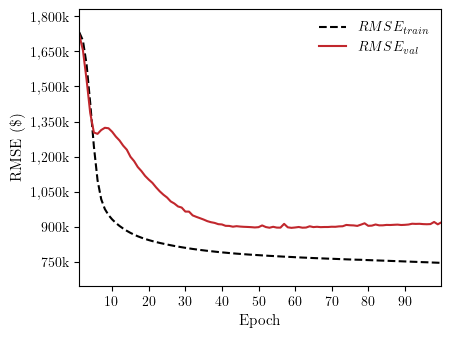

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

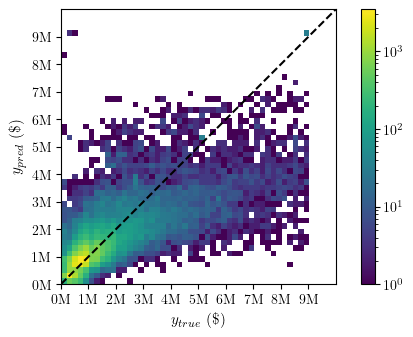

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')